# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [1]:
import gym
from gym.spaces import Box
import numpy as np

try:
    import cv2
except ImportError:
    cv2 = None

In [2]:
# bring observation in desired shape and scale observation between 0 and 1
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):

        obs = cv2.resize(obs, (self.screen_size, self.screen_size))#, interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64)).unsqueeze(0)
        return obs
        
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal

import matplotlib.pyplot as plt

# V-Model

In [4]:
class VAE():
    def __init__(self, state_size, latent_size_N=32, device="cpu"):
              
        self.encoder = Encoder(state_size, latent_size_N).to(device)
        self.decoder = Decoder(state_size, latent_size_N).to(device)
        self.device = device
        
        self.params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.Adam(params=self.params, lr=0.001)
        #self.optimizer_decoder = optim.Adam(params=self.decoder.parameters(), lr=0.0001)
        
    def forward(self, image: torch.Tensor)-> torch.Tensor:
        
        assert image.shape == (image.shape[0] ,3, 64, 64), "Input Image as wrong shape!"
        mu, sig = self.encoder(image)
        encoded = self.sample(mu, sig)
        
        decoded = self.decoder(encoded)
        return decoded, (mu, sig)
    
    def encode_state(self, image: torch.Tensor)-> torch.Tensor:
        assert image.shape == (image.shape[0], 3, 64, 64), "Input Image as wrong shape!"
        (mu, logsig) = self.encoder(image)
        encoded = self.sample(mu, logsig)
        return encoded
    
    def sample(self, mu, logsig):
            
        #dist = Normal(mu, sig) 
        #latent_vector_z = dist.sample()
        
        # in the paper they had different sample methods this one and mu + sig *N(0,1)
        #latent_vector_z = mu + sig * torch.normal(torch.zeros(1), torch.ones(1)).to(device)
        
        
        sigma = logsig.exp()
        eps = torch.randn_like(sigma)     
        return eps.mul(sigma).add_(mu)
        
    def train(self, dataloader:DataLoader)-> torch.Tensor:
        losses = {"loss1": [], "loss2": []}
        for idx, sample in enumerate(dataloader):
            
            image_batch = sample[0].to(device)
            reconstructed, (mu, sig) = self.forward(image_batch)
            
            loss_1 = kl_loss(mu, sig)
            loss_2 = l2_dist_loss(reconstructed, image_batch)
            
            self.optimizer.zero_grad()
            loss = (loss_1 + loss_2).mean()
            
            loss.backward()
            #clip_grad_norm_(self.params, 10.)
            self.optimizer.step()
            losses["loss1"].append(loss_1.detach().cpu().numpy())
            losses["loss2"].append(loss_2.detach().cpu().numpy())
        return np.mean(losses["loss1"]),np.mean(losses["loss2"]) 
            
            

def kl_loss(mu: torch.Tensor, sig:torch.Tensor)-> torch.Tensor:
    #loss = - 0.5 * (1 + torch.log(sig).pow(2) - sig.pow(2) - mu.pow(2)).sum()
    loss = -0.5 * torch.sum(1 + 2 * sig - mu.pow(2) - (2 * sig).exp())
    return loss

def l2_dist_loss(prediction:torch.Tensor, target:torch.Tensor)-> torch.Tensor:
    #return - torch.dist(target,prediction, p=2)
    return F.mse_loss(prediction, target, size_average=False)
    #return F.binary_cross_entropy(prediction, target, size_average=False)
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        #self.softplus = nn.Softplus() #use different activation?
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        #print(x.shape)
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.relu(self.conv3(x))
        #print(x.shape)
        x = torch.relu(self.conv4(x))
        #print(x.shape)
        
        mu = self.output_mu(x.flatten(1)) #torch.tanh()
        log_sig = self.output_sig(x.flatten(1))#self.softplus()
        #sig = torch.sqrt(var)
                    
        return (mu, log_sig)

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        #print(x.shape)
        x = torch.relu(self.deconv2(x))
        #print(x.shape)
        x = torch.relu(self.deconv3(x))
        #print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        #print(x.shape)
        return x

# Create Samples with random policy


In [5]:
Episodes = 10
env = gym.make("CarRacing-v0")
env = MaxAndSkipEnv(env)
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)
state_size = env.observation_space.shape
action_size = env.action_space.shape[0]

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:

samples = {"states":[], "actions": [], "rewards": [], "dones":[]}

for ep in range(Episodes):
    done=False
    state = env.reset()
    step_count = 0 ## First ~50 steps is zooming to start position. not needed for training
    while True:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        step_count += 1
        
        if step_count > 50:
            samples["states"].append(state)
            samples["actions"].append(action)
            samples["rewards"].append(reward)
            samples["dones"].append(done)
        if done:
            print("Ep: {} | Sample size: {}".format(ep, len(samples["states"])))
            break
        

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1215..1523 -> 308-tiles track
Ep: 0 | Sample size: 200
Track generation: 1120..1404 -> 284-tiles track
Ep: 1 | Sample size: 400
Track generation: 1152..1445 -> 293-tiles track
Ep: 2 | Sample size: 600
Track generation: 1280..1604 -> 324-tiles track
Ep: 3 | Sample size: 800
Track generation: 1031..1293 -> 262-tiles track
Ep: 4 | Sample size: 1000
Track generation: 1271..1593 -> 322-tiles track
Ep: 5 | Sample size: 1200
Track generation: 1172..1469 -> 297-tiles track
Ep: 6 | Sample size: 1400
Track generation: 1172..1469 -> 297-tiles track
Ep: 7 | Sample size: 1600
Track generation: 1336..1675 -> 339-tiles track
Ep: 8 | Sample size: 1800
Track generation: 1144..1434 -> 290-tiles track
Ep: 9 | Sample size: 2000


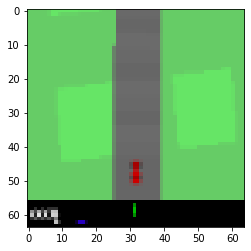

In [6]:
plt.imshow(samples["states"][4].squeeze().reshape(64,64,3))

# Create Dataset 

In [7]:
# Create Dataset of states
set = torch.cat(samples["states"], dim=0)
dataset = TensorDataset(set)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
V_model = VAE(state_size=(3, 64, 64), device=device)
print("Using: {}".format(device))

Using: cuda:0


In [11]:
Epochs = 150
losses = {"loss1": [], "loss2": [], "loss": []}
for i in range(Epochs):
    loss1, loss2 = V_model.train(dataloader)
    print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2), end="", flush=True)
    if i % 10 == 0:
        print("\rEpoch: {} | kl_loss: {:.2f} | l2_loss: {:.2f} | combines loss: {:.2f}".format(i, loss1, loss2, loss1+loss2))
        
    losses["loss1"].append(loss1)    
    losses["loss2"].append(loss2)    
    losses["loss"].append(loss1+loss2)

Epoch: 0 | kl_loss: 71.90 | l2_loss: 169813.84 | combines loss: 169885.75
Epoch: 10 | kl_loss: 21.05 | l2_loss: 28028.80 | combines loss: 28049.84
Epoch: 20 | kl_loss: 32.07 | l2_loss: 25725.03 | combines loss: 25757.10
Epoch: 30 | kl_loss: 55.31 | l2_loss: 24758.92 | combines loss: 24814.22
Epoch: 40 | kl_loss: 696.14 | l2_loss: 20248.38 | combines loss: 20944.52
Epoch: 50 | kl_loss: 681.27 | l2_loss: 16865.11 | combines loss: 17546.38
Epoch: 60 | kl_loss: 836.19 | l2_loss: 14402.72 | combines loss: 15238.91
Epoch: 70 | kl_loss: 1080.46 | l2_loss: 12009.75 | combines loss: 13090.21
Epoch: 80 | kl_loss: 1121.50 | l2_loss: 10920.79 | combines loss: 12042.28
Epoch: 90 | kl_loss: 1168.48 | l2_loss: 10220.07 | combines loss: 11388.54
Epoch: 100 | kl_loss: 1433.07 | l2_loss: 9053.36 | combines loss: 10486.43
Epoch: 110 | kl_loss: 1532.24 | l2_loss: 8559.24 | combines loss: 10091.48
Epoch: 120 | kl_loss: 1603.85 | l2_loss: 8094.52 | combines loss: 9698.372
Epoch: 130 | kl_loss: 1574.58 | l2_

<function matplotlib.pyplot.show(close=None, block=None)>

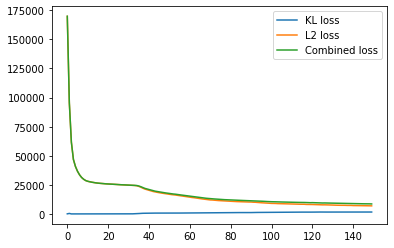

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses["loss1"], label="KL loss")
plt.plot(losses["loss2"], label="L2 loss")
plt.plot(losses["loss"], label="Combined loss")
plt.legend()

plt.show

In [13]:
# safe / load state dict

torch.save(V_model.encoder.state_dict(), "Encoder.pth")
torch.save(V_model.decoder.state_dict(), "Decoder.pth")

In [7]:
V_model.encoder.load_state_dict(torch.load("Encoder.pth"))
V_model.decoder.load_state_dict(torch.load("Decoder.pth"))

<All keys matched successfully>

# Observe training results

State number: 258


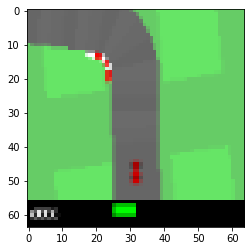

In [16]:
len(samples["states"])
nr = np.random.randint(len(samples["states"]))
print("State number:", nr)
example_image = samples["states"][nr]
# select example image
plt.imshow(example_image.squeeze().reshape(64,64,3))

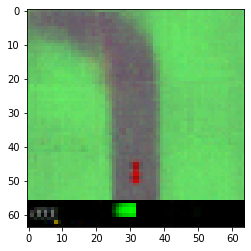

In [17]:
# view reconstructed image
reconstr, _ = V_model.forward(example_image.to(device))
plt.imshow(reconstr.detach().cpu().numpy().reshape(64,64,3))

# M-Model

In [80]:
class MModel(nn.Module):
    def __init__(self, action_size, latent_size=32, hidden_size=256, batch_size=64, n_gaussians=5, rnn_type="LSTM"):
        super(MModel, self).__init__()
        
        self.input_shape = action_size+latent_size
        self.action_size = action_size
        self.latent_size = latent_size
        self.n_gaussians = n_gaussians
        self.batch_size = batch_size
        
        if rnn_type == "LSTM":
            self.rnn_layer = nn.LSTM(self.input_shape, hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn_layer = nn.GRU(self.input_shape, hidden_size, batch_first=True)
            
        self.pi_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.mu_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.sig_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        
        
    def forward(self, latent_vector: torch.Tensor, action:torch.Tensor, hidden_state=None)-> torch.Tensor:
        """ Simple forward pass with the RNN """
        
        assert latent_vector.shape == (latent_vector.shape[0], self.latent_size), "Latent vector has the wrong shape!"
        assert action.shape == (action.shape[0], self.action_size), "Action batch has the wrong shape!"
        
        input_tensor = torch.cat((latent_vector, action),dim=1).unsqueeze(1)
        assert input_tensor.shape == (action.shape[0], 1, self.input_shape), "input_tensor has wrong shape!"
        
        output, hidden_state = self.rnn_layer(input_tensor, hidden_state)
        
        (pi, mu, sigma) = self.get_gauss_coeffs(output)
        return (pi, mu, sigma), hidden_state
    
    
    def get_gauss_coeffs(self, y:torch.Tensor):
        
        rollout_length = y.size(1)
        
        pi = self.pi_layer(y)
        mu = self.mu_layer(y)
        sigma = self.sig_layer(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
    
    def predict_next_z(self,latent_vector: torch.Tensor, action:torch.Tensor, tau: float, hidden_state=None)-> torch.Tensor:
        """ Predicts the next Latent Vector Z """
        values, hidden_state = self.forward(latent_vector, action, hidden_state)
        mu, sigma = values[1], values[2]
        
        dist = Normal(mu, sigma*tau)
        z_ = dist.sample().mean(2)
        
        #prediction = [torch.normal(mu, sigma)[:, :, i, :] for i in range(self.n_gaussians)]
        return z_, hidden_state
        
# M-Model loss calculation
def mdn_loss_fn(y, pi, mu, sigma):
    m = Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()


def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [83]:
action_size = env.action_space.shape[0]
m_model = MModel(action_size=action_size)

In [86]:
M_optimizer = optim.Adam(params=m_model.parameters(), lr=0.001)


NameError: name 'samples' is not defined

# C-Model

In [8]:
class C_Model(nn.Module):
    def __init__(self, action_size, hidden_size=256, latent_size=32, device="cpu"):
        super(C_Model, self).__init__()
        
        self.device = device
        self.action_size = action_size
        
        self.layer_1 = nn.Linear(latent_size*2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, action_size)
        
        
    def forward(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """
        input_ = torch.cat((latent_vector, hidden_state), dim=1)
        x = torch.relu(self.layer_1(input_))
        x = torch.tanh(self.layer_2(x)) 
        # add var to prediction as well
        return x
    
    def get_action(self, latent_vector:torch.Tensor, hidden_state:torch.Tensor)-> torch.Tensor:
        """  """
        mu = self.forward(latent_vector, hidden_state)
        dist = Normal(mu, torch.ones(1).to(self.device))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action, log_prob
    

def calc_discounted_rewards(rewards, final_state, gamma = 0.99):
    R = 0
    discounted = []
  
    for idx in reversed(range(len(rewards))):
        R = rewards[idx]+R*gamma *final_state[idx]
        discounted.insert(0,R)
    return discounted
    
def update_cmodel(log_pis:torch.Tensor, rewards:torch.Tensor)-> np.array:
    """ Updating the C-Model in a PG-Style """
    assert log_pis.shape[0] == rewards.shape[0]
    
    c_model_optim.zero_grad()
    loss = (-log_pis*(rewards-rewards.mean())).sum()
    loss.backward()
    c_model_optim.step()
    return loss.detach().cpu().numpy()

In [9]:
action_size = env.action_space.shape[0]
c_model = C_Model(action_size, device=device).to(device)

In [10]:
c_model_optim = optim.Adam(params=c_model.parameters(), lr=0.001)

## Train without M-Model

Train the C-Model in Policy Gradient Style without the M-Model!

In [ ]:
episodes = 100
c_model_rewards = []
high_action = env.action_space.high
low_action = env.action_space.low
for ep in range(episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    
    reward_batch = []
    dones_batch = []
    log_prob_batch = []
    
    while True:

        latent_vector_z = V_model.encode_state(state.to(device))
        zero_hidden = torch.zeros_like(latent_vector_z).to(device)
        action, log_prob = c_model.get_action(latent_vector_z, zero_hidden)
        
        action = np.asarray(np.clip(action.detach().cpu().numpy(), a_min=low_action, a_max=high_action), dtype=np.float32).squeeze()

        state, reward, done, _ = env.step(action)
        
        reward_batch.append(reward)
        dones_batch.append(1-int(done))
        log_prob_batch.append(log_prob)
        
        episode_rewards += reward
        
        if done:
            break
            
    rewards = calc_discounted_rewards(reward_batch, dones_batch)

    loss = update_cmodel(torch.cat(log_prob_batch, dim=0),
                         torch.FloatTensor(rewards).unsqueeze(-1).to(device))
    
    c_model_rewards.append(episode_rewards)    
            
    print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss), end="", flush=True)
    if ep % 10 == 0:
        print("\rEpoch: {} | Reward: {:.2f} | Loss: {:.2f}".format(ep, episode_rewards, loss))
            
    
        

Track generation: 968..1218 -> 250-tiles track
Epoch: 0 | Reward: -23.69 | Loss: -190.43
Track generation: 1082..1357 -> 275-tiles track
Epoch: 1 | Reward: -70.80 | Loss: 27.70Track generation: 1431..1793 -> 362-tiles track
Epoch: 2 | Reward: -52.91 | Loss: -97.38Track generation: 1150..1442 -> 292-tiles track
Epoch: 3 | Reward: -31.27 | Loss: -197.70Track generation: 1156..1449 -> 293-tiles track
Epoch: 4 | Reward: -62.33 | Loss: 125.76Track generation: 1264..1584 -> 320-tiles track
Epoch: 5 | Reward: -71.79 | Loss: 132.63Track generation: 1234..1546 -> 312-tiles track
Epoch: 6 | Reward: -77.49 | Loss: -123.33Track generation: 1157..1451 -> 294-tiles track
Epoch: 7 | Reward: -31.74 | Loss: 237.11Track generation: 1192..1494 -> 302-tiles track
Epoch: 8 | Reward: -53.49 | Loss: -43.13Track generation: 1145..1435 -> 290-tiles track
Epoch: 9 | Reward: -41.18 | Loss: 272.84Track generation: 1300..1629 -> 329-tiles track


In [34]:
torch.FloatTensor(rewards).unsqueeze(-1).shape

torch.Size([250, 1])

In [35]:
torch.cat(log_prob_batch, dim=0).shape

torch.Size([250, 3])